# Food Recipe Recommender System
#### Ell June Abucay and Veronica Bayani

Food.com (also formerly known as Genius Kitchen) is a website that provides information related to food, cooking, and recipes. The dataset that will be used is crawled data from Food.com (GeniusKitchen) and is available in Kaggle through this link: https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions

Our goal is to build a recommender system that will recommend food recipes based on the user's ratings of other recipes. For the purposes of this exercise we will focus on using Collaborative Filtering as our approach.

This dataset consists of 180K+ recipes and 700K+ recipe reviews covering 18 years of user interactions and uploads on Food.com (formerly GeniusKitchen).

## Content

These two dataset will be used for this exercise:

* interactions_test.csv
* raw_recipe.csv


## Libraries

In [1]:
# allows us to access dataframes
import pandas as pd

# specialized class for handling sparse matrices (compressed)
from scipy.sparse import csr_matrix

# Library for visualizing charts
import matplotlib.pylab as plt

# Gives us access to the unsupervised algorithm knn 
from sklearn.neighbors import NearestNeighbors

# Surprise is an easy-to-use Python scikit for recommender systems.
from surprise import SVD #SVD algorithm
from surprise import KNNBasic # Knn algorithm
from surprise import Dataset # Utility for loading datasets
from surprise import Reader # Allows surprise to interpret the ratings
from surprise.model_selection import cross_validate # cross validation utility

## Exploration

For this food recommender, we will get our information from 2 datasets namely interactions_test.csv and RAW_recipes.csv. Both of the datasets are available for download at https://www.kaggle.com/datasets/shuyangli94/food-com-recipes-and-user-interactions.

Loading the RAW_recipes dataset,

In [3]:
recipes_raw_df = pd.read_csv("c:/Users/DepEd/Documents/PMDSA/Stat 208/RAW_recipes.csv")

In [4]:
recipes_raw_df.head()

name      id  minutes  \
0  arriba   baked winter squash mexican style  137739       55   
1            a bit different  breakfast pizza   31490       30   
2                   all in the kitchen  chili  112140      130   
3                          alouette  potatoes   59389       45   
4          amish  tomato ketchup  for canning   44061      190   

   contributor_id   submitted  \
0           47892  2005-09-16   
1           26278  2002-06-17   
2          196586  2005-02-25   
3           68585  2003-04-14   
4           41706  2002-10-25   

                                                tags  \
0  ['60-minutes-or-less', 'time-to-make', 'course...   
1  ['30-minutes-or-less', 'time-to-make', 'course...   
2  ['time-to-make', 'course', 'preparation', 'mai...   
3  ['60-minutes-or-less', 'time-to-make', 'course...   
4  ['weeknight', 'time-to-make', 'course', 'main-...   

                                    nutrition  n_steps  \
0       [51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]       11   
1   [173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]        9   
2  [269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]        6   
3   [368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]       11   
4   [352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]        5   

                                               steps  \
0  ['make a choice and proceed with recipe', 'dep...   
1  ['preheat oven to 425 degrees f', 'press dough...   
2  ['brown ground beef in large pot', 'add choppe...   
3  ['place potatoes in a large pot of lightly sal...   
4  ['mix all ingredients& boil for 2 1 / 2 hours ...   

                                         description  \
0  autumn is my favorite time of year to cook! th...   
1  this recipe calls for the crust to be prebaked...   
2  this modified version of 'mom's' chili was a h...   
3  this is a super easy, great tasting, make ahea...   
4  my dh's amish mother raised him on this recipe...   

                                         ingredients  n_ingredients  
0  ['winter squash', 'mexican seasoning', 'mixed ...              7  
1  ['prepared pizza crust', 'sausage patty', 'egg...              6  
2  ['ground beef', 'yellow onions', 'diced tomato...             13  
3  ['spreadable cheese with garlic and herbs', 'n...             11  
4  ['tomato juice', 'apple cider vinegar', 'sugar...              8

In [9]:
recipes_raw_df = recipes_raw_df.drop_duplicates()
recipes_raw_df.shape

(231637, 12)

### Checking for the data types per column

In [8]:
# Let's check the data types

recipes_raw_df.dtypes

name              object
id                 int64
minutes            int64
contributor_id     int64
submitted         object
tags              object
nutrition         object
n_steps            int64
steps             object
description       object
ingredients       object
n_ingredients      int64
dtype: object

##### According to Kaggle, these are the descriptions per column of recipes_raw_df:
* name - Recipe name
* id - Recipe ID
* minutes - Minutes to prepare recipe
* contributor_id - User ID who submitted this recipe
* submitted - Date recipe was submitted
* tags - Food.com tags for recipe
* nutrition - Nutrition information (calories (#), total fat (PDV), sugar (PDV) , sodium (PDV) , protein (PDV) , saturated fat
* n_steps - Number of steps in recipe
* steps - Text for recipe steps, in order
* description - User-provided description
* ingredients - List of ingredient names
* n_ingredients - Number of ingredients

In [10]:
#understand unique recipe counts per user for the dataset

num_contributors = len(recipes_raw_df.contributor_id.unique())
num_recipes = len(recipes_raw_df.id.unique())
print('There are {} unique users and {} unique recipes in this data set'.format(num_contributors, num_recipes))

There are 27926 unique users and 231637 unique recipes in this data set


On average, how many recipes is each user contributing?

id    3118
dtype: int64

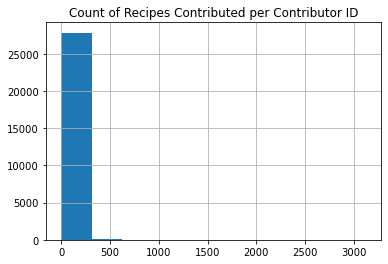

In [14]:
recipes_raw_df[['contributor_id','id']].groupby(['contributor_id']).count().hist()
plt.title("Count of Recipes Contributed per Contributor ID")

In [13]:
recipes_raw_df[['contributor_id','id']].groupby(['contributor_id']).count().describe()

id
count  27926.000000
mean       8.294672
std       49.108016
min        1.000000
25%        1.000000
50%        1.000000
75%        3.000000
max     3118.000000

There are 27,926 unique users contributing an average of 8.29 recipes in the raw dataset.

Loading the interactions_train dataset,

In [16]:
interactions_df = pd.read_csv("c:/Users/DepEd/Documents/PMDSA/Stat 208/interactions_train.csv")

In [17]:
interactions_df.head()

user_id  recipe_id        date  rating      u       i
0     2046       4684  2000-02-25     5.0  22095   44367
1     2046        517  2000-02-25     5.0  22095   87844
2     1773       7435  2000-03-13     5.0  24732  138181
3     1773        278  2000-03-13     4.0  24732   93054
4     2046       3431  2000-04-07     5.0  22095  101723

In [18]:
#Removing of duplicates
interactions_df = interactions_df.drop_duplicates()
interactions_df.shape

(698901, 6)

##### According to Kaggle, these are the descriptions per column in the interactions_df:
* user_id - User ID
* recipe_id - Recipe ID
* date - Date of interaction
* rating - Rating given
* u - User ID, mapped to contiguous integers from 0
* i - Recipe ID, mapped to contiguous integers from 0

In [20]:
#Checking the number of recipes contributed per user
num_users_interactions = len(interactions_df.user_id.unique())
num_recipes_interactions = len(interactions_df.recipe_id.unique())
print('There are {} unique users and {} unique recipes in this data set'.format(num_users_interactions, num_recipes_interactions))

There are 25076 unique users and 160901 unique recipes in this data set


Text(0.5, 1.0, 'Count of Recipe Ratings per User Id')

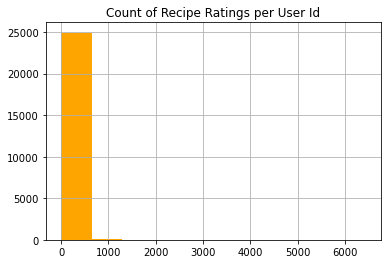

In [24]:
#Checking how many ratings per user ID do we have

interactions_df[['user_id','rating']].groupby(['user_id']).count().hist(color = "orange")
plt.title("Count of Recipe Ratings per User Id")

<AxesSubplot:title={'center':'Count of Rating Score'}>

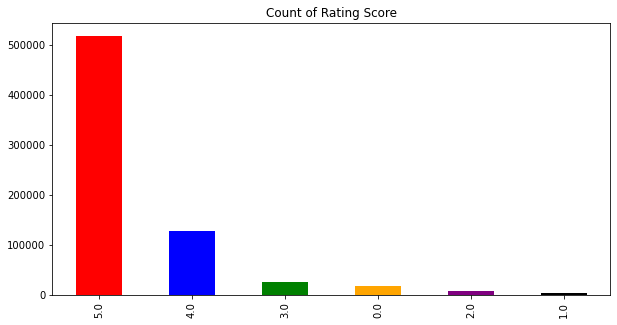

In [26]:
#Checking the distribution of the ratings

colors = ['red', 'blue', 'green', 'orange', 'purple', 'black']
interactions_df['rating'].value_counts().plot.bar(title="Count of Rating Score",figsize=(10,5), color = colors)

The ratings range from 0 to 5.

##### Selecting the user_id, recipe_id and rating columns from the interactions_df:

In [27]:
interactions_subset=interactions_df[["user_id", "recipe_id","rating"]]
interactions_subset.head()

user_id  recipe_id  rating
0     2046       4684     5.0
1     2046        517     5.0
2     1773       7435     5.0
3     1773        278     4.0
4     2046       3431     5.0

In [33]:
interactions_subset.shape # we have 698901 observations for this dataset

(698901, 3)

##### Selecting the id, minutes, name and ingredients in the recipes_raw_df:

In [34]:
recipes_raw_subset=recipes_raw_df[["id", "minutes","name","ingredients"]]
recipes_raw_subset.head()

id  minutes                                        name  \
0  137739       55  arriba   baked winter squash mexican style   
1   31490       30            a bit different  breakfast pizza   
2  112140      130                   all in the kitchen  chili   
3   59389       45                          alouette  potatoes   
4   44061      190          amish  tomato ketchup  for canning   

                                         ingredients  
0  ['winter squash', 'mexican seasoning', 'mixed ...  
1  ['prepared pizza crust', 'sausage patty', 'egg...  
2  ['ground beef', 'yellow onions', 'diced tomato...  
3  ['spreadable cheese with garlic and herbs', 'n...  
4  ['tomato juice', 'apple cider vinegar', 'sugar...

In [44]:
recipes_raw_subset.dtypes #let's check the data types in our recipe dataset

id              int64
minutes         int64
name           object
ingredients    object
dtype: object

In [48]:
recipes_raw_subset.shape

(231637, 4)

In [51]:
# Check the unique name of the recipes in our dataset
recipes_raw_subset['name'].nunique

<bound method IndexOpsMixin.nunique of 62046                                creamed onions iii
132680                               meatless chili iii
132541                                 meatball soup ii
132466                                    meat rissoles
132419                          meat and potato squares
                              ...                      
106963                                 homemade vanilla
38116     celtic druid s honey mead   meade   metheglin
106563                           homemade fruit liquers
109624                        how to preserve a husband
144074                            no bake granola balls
Name: name, Length: 231637, dtype: object>

## Preprocessing the data

In [54]:
#filtering for the recipes with at least 1 rating

minimum_rating_thres = 1  # we want to make sure that each recipe has been rated once
recipe_rating_cnt_df = interactions_subset[['rating','recipe_id']].groupby(['recipe_id']).count()
#recipe_rating_cnt_df
popular_recipes_df = recipe_rating_cnt_df[recipe_rating_cnt_df['rating']>=minimum_rating_thres]
#popular_recipes_df


filtered_pop_recipes_df = interactions_subset[interactions_subset.recipe_id.isin(popular_recipes_df.index.values)]
print('shape of original ratings data: ', interactions_subset.shape)
print('shape of ratings data after dropping recipes with no rating: ', filtered_pop_recipes_df.shape)

shape of original ratings data:  (698901, 3)
shape of ratings data after dropping recipes with no rating:  (698901, 3)


###### After implementing the threshold, we found out that there are no recipes with no rating in our dataset.

In [56]:
#filtering for active users
ratings_thres = 1 # we want to make sure that each user has at least one rating.
#max_thres= 500

active_users_cnt_df = interactions_subset[['user_id','recipe_id']].groupby(['user_id']).count()
#active_users_cnt_df
active_users_df = active_users_cnt_df[active_users_cnt_df['recipe_id']>=ratings_thres]
#active_users_df

filtered_popular_active_df = filtered_pop_recipes_df[filtered_pop_recipes_df.index.isin(active_users_df.index.values)]
print('shape of original ratings data: ', filtered_pop_recipes_df.shape)
print('shape of ratings data after dropping both the recipes with no rating and inactive users: ', filtered_popular_active_df.shape)

shape of original ratings data:  (698901, 3)
shape of ratings data after dropping both the recipes with no rating and inactive users:  (17031, 3)


From 698,901 observations, we now reduced them to 17031.

In [58]:
# sample from our filtered data

filtered_popular_active_df.head()

user_id  recipe_id  rating
1533    29110      15690     5.0
1535    20371      17092     5.0
1634    21399      15241     5.0
1676    16777       4285     4.0
1773    27643      10125     5.0

Performing a left join using the filtered_popular_active_df and recipes_raw_subset:

In [60]:
recipes_main_merged=pd.merge(filtered_popular_active_df, recipes_raw_subset, left_on='recipe_id', right_on='id')
recipes_main_merged

# we now have 7 columns for the merged data set

user_id  recipe_id  rating      id  minutes  \
0           29110      15690     5.0   15690     1450   
1           25045      15690     5.0   15690     1450   
2          381538      15690     5.0   15690     1450   
3           20371      17092     5.0   17092       50   
4           23333      17092     3.0   17092       50   
...           ...        ...     ...     ...      ...   
17026      226863     258850     5.0  258850       40   
17027     1924722     223588     5.0  223588       20   
17028  2000498330     297870     4.0  297870       60   
17029  2000498330     417849     5.0  417849       85   
17030      266635     534108     5.0  534108       45   

                                            name  \
0                            bulgogi  korean bbq   
1                            bulgogi  korean bbq   
2                            bulgogi  korean bbq   
3      auntie lori s swedish meatballs casserole   
4      auntie lori s swedish meatballs casserole   
...                                          ...   
17026                midwestern style beer brats   
17027                       tex mex kraft dinner   
17028                  wild west baked chili mac   
17029                          apple turkey loaf   
17030        corn casserole   minus creamed corn   

                                             ingredients  
0      ['rib eye steaks', 'sugar', 'soy sauce', 'garl...  
1      ['rib eye steaks', 'sugar', 'soy sauce', 'garl...  
2      ['rib eye steaks', 'sugar', 'soy sauce', 'garl...  
3      ['hamburger', 'egg', 'breadcrumbs', 'carrots',...  
4      ['hamburger', 'egg', 'breadcrumbs', 'carrots',...  
...                                                  ...  
17026  ['bratwursts', 'lager beer', 'onions', 'olive ...  
17027  ['kraft macaroni and cheese', 'butter', 'low-f...  
17028  ['velveeta shells and cheese dinner', 'chili w...  
17029  ['margarine', 'tart apples', 'onion', 'turkey ...  
17030  ['milk', 'heavy cream', 'butter', 'sugar', 'fl...  

[17031 rows x 7 columns]

In [61]:
# We will drop 'id' since it is redundant with the 'recipe_id'.
recipes_main_merged = recipes_main_merged.drop(columns=["id"])

In [62]:
recipes_main_merged

user_id  recipe_id  rating  minutes  \
0           29110      15690     5.0     1450   
1           25045      15690     5.0     1450   
2          381538      15690     5.0     1450   
3           20371      17092     5.0       50   
4           23333      17092     3.0       50   
...           ...        ...     ...      ...   
17026      226863     258850     5.0       40   
17027     1924722     223588     5.0       20   
17028  2000498330     297870     4.0       60   
17029  2000498330     417849     5.0       85   
17030      266635     534108     5.0       45   

                                            name  \
0                            bulgogi  korean bbq   
1                            bulgogi  korean bbq   
2                            bulgogi  korean bbq   
3      auntie lori s swedish meatballs casserole   
4      auntie lori s swedish meatballs casserole   
...                                          ...   
17026                midwestern style beer brats   
17027                       tex mex kraft dinner   
17028                  wild west baked chili mac   
17029                          apple turkey loaf   
17030        corn casserole   minus creamed corn   

                                             ingredients  
0      ['rib eye steaks', 'sugar', 'soy sauce', 'garl...  
1      ['rib eye steaks', 'sugar', 'soy sauce', 'garl...  
2      ['rib eye steaks', 'sugar', 'soy sauce', 'garl...  
3      ['hamburger', 'egg', 'breadcrumbs', 'carrots',...  
4      ['hamburger', 'egg', 'breadcrumbs', 'carrots',...  
...                                                  ...  
17026  ['bratwursts', 'lager beer', 'onions', 'olive ...  
17027  ['kraft macaroni and cheese', 'butter', 'low-f...  
17028  ['velveeta shells and cheese dinner', 'chili w...  
17029  ['margarine', 'tart apples', 'onion', 'turkey ...  
17030  ['milk', 'heavy cream', 'butter', 'sugar', 'fl...  

[17031 rows x 6 columns]

In [63]:
#Creating a data frame with only user_id, recipe_id, rating and minutes

recipe_main=recipes_main_merged.drop(columns=["name","ingredients"])
recipe_main.head()

user_id  recipe_id  rating  minutes
0    29110      15690     5.0     1450
1    25045      15690     5.0     1450
2   381538      15690     5.0     1450
3    20371      17092     5.0       50
4    23333      17092     3.0       50

In [66]:
recipe_main.shape # we are now left with four columns

(17031, 4)

### Creating a sparse matrix

In [67]:
recipes_mat = csr_matrix(recipe_main.values)
recipes_mat

<17031x4 sparse matrix of type '<class 'numpy.float64'>'
	with 67687 stored elements in Compressed Sparse Row format>

### Using KNN to estimate the distance

In [68]:
# Metric is the distance algorithm to be used. You can find more choices here: 
# https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric

# algorithm is the type of tree search used by the model
# neighbors it the amount of neighbors identified

model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

# fit

model_knn.fit(recipes_mat)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

Let's try it out:

In [70]:
fav_recipe = "steak"
print('You have your favorite food as:', fav_recipe)

# find recipe or food keywords that "match" fav_recipe

recipe_matches_df = recipes_main_merged[recipes_main_merged['name'].str.contains(fav_recipe)]  
recipe_matches_df

You have your favorite food as: steak


user_id  recipe_id  rating  minutes  \
203      28201      36910     5.0      375   
254      41531      37987     5.0       60   
310      35848      13949     4.0      495   
311      64934      13949     5.0      495   
355      50313      37365     5.0      105   
...        ...        ...     ...      ...   
16713   440735     109930     5.0       15   
16876  2200124     518229     5.0       25   
16892   386585     395873     5.0       20   
16934   169430     504042     5.0      142   
17000  1436160     167581     5.0       35   

                                                    name  \
203                  crock pot flank steak with linguini   
254                                barbecued fish steaks   
310                      cube steak and gravy  crock pot   
311                      cube steak and gravy  crock pot   
355                          cube steak w mushroom gravy   
...                                                  ...   
16713                  barbecue halibut or salmon steaks   
16876  charge me up a1 steak   egg veggie breakfast w...   
16892                rib eye steaks with dijon gremolata   
16934                                     jamaican steak   
17000  grilled steak salad with crumbly bleu salad dr...   

                                             ingredients  
203    ['flank steaks', 'butter', 'dried thyme', 'dri...  
254    ['salmon fillets', 'onion', 'garlic', 'butter'...  
310    ['cube steaks', 'salt', 'pepper', 'flour', 'on...  
311    ['cube steaks', 'salt', 'pepper', 'flour', 'on...  
355    ['cube steaks', 'salt', 'pepper', 'garlic powd...  
...                                                  ...  
16713  ['butter', 'brown sugar', 'garlic cloves', 'le...  
16876  ['a.1. original sauce', 'extra virgin olive oi...  
16892  ['rib eye steaks', 'seasoning salt', 'fresh gr...  
16934  ['beef flank steak', 'brown sugar', 'orange ju...  
17000  ['olive oil', 'red wine vinegar', 'lemon juice...  

[242 rows x 6 columns]

In [75]:
print("\033[1m\n\n\nLet's start making recommendations!...\033[0m")

if(recipe_matches_df is  None):
    print("No Matching recipes :(")
    
else:
    
    # Indicate the top recommendations we want to get (how many neighbors should we find?)
    top_recommendations = 10

    recipe_idx= recipe_matches_df.iloc[0]['recipe_id'] # select the first recipe in the list, get the recipe Id
    
    # get the dataframe index from the recipe id
    recipe_idx = recipes_main_merged[recipes_main_merged['recipe_id'] == recipe_idx].index[0]

    # model will return a list of distances and indices
    distances , indices = model_knn.kneighbors(recipes_mat[recipe_idx],n_neighbors=top_recommendations+1)    

    # transform the result into a list
    rec_recipe_indices = sorted(list(zip(indices.squeeze().tolist(),distances.squeeze().tolist())),key=lambda x: x[1])[:0:-1]
    recommend_frame = [] #let's create an empty list
 
    # we will iterate thru the results and add them to the list
    for val in rec_recipe_indices:
        
        # we get the recipe id
        recipe_idx = recipes_main_merged.iloc[val[0]]['recipe_id']
        # convert into an index, we will this use to get the recipe name
        idx = recipes_main_merged[recipes_main_merged['recipe_id'] == recipe_idx].index
        # take the recipe name together with the computed "distance". This distance is how far the recipes are from the 'target' recipe
        recommend_frame.append({'Recipe':recipes_main_merged.iloc[idx]['name'].values[0],'Distance':val[1]})

    # place resulting list inside a dataframe
    df = pd.DataFrame(recommend_frame,index=range(1,top_recommendations+1))
    display(df.sort_values("Distance")) #sort by distance to get the top 10





Let's start making recommendations!...


Recipe  Distance
10      fruit filled coffee cake  0.000005
9        cabbage and onion salad  0.000007
8       crunchy nut lentil roast  0.000012
7   quick french onion meatballs  0.000013
6    slow cooker beef short ribs  0.000018
5           buttermilk bread abm  0.000021
4                  harvest bread  0.000022
3               autumn beef stew  0.000024
2               pickled radishes  0.000024
1         pearl s sesame noodles  0.000024

In [77]:
# Let's use surprise library to get a measure of our knn model's RMSE metric
# The Reader class is used to parse a file containing ratings.
# A reader is still needed but only the rating_scale param is required.

reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(recipes_main_merged[['user_id', 'recipe_id', 'rating']], reader)

# We'll train a knn model in surprise using our same data set
knnbasic = KNNBasic()

# Run 5-fold cross-validation and print results.
knn_results = cross_validate(knnbasic, data, measures=['RMSE'], cv=5, verbose=True)
knn_results


# Smaller RMSE means our model is able to give better recommendation

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9317  0.9236  0.9405  0.9206  0.9165  0.9266  0.0086  
Fit time          0.41    0.43    0.47    0.56    0.49    0.47    0.05    
Test time         0.03    0.03    0.03    0.03    0.03    0.03    0.00    


{'test_rmse': array([0.93171877, 0.92362643, 0.94050956, 0.92062793, 0.91652871]),
 'fit_time': (0.407956600189209,
  0.43094658851623535,
  0.470020055770874,
  0.5634064674377441,
  0.48705267906188965),
 'test_time': (0.02612614631652832,
  0.02724146842956543,
  0.02694082260131836,
  0.027773380279541016,
  0.031488895416259766)}

## Model based approach

In [78]:
# A reader is still needed but only the rating_scale param is required.
reader = Reader(rating_scale=(0, 5)) #our scale is still from 0 to 5

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(recipes_main_merged[['user_id', 'recipe_id', 'rating']], reader)

# Use the famous SVD algorithm
algo = SVD()

# Run 5-fold cross-validation and print results.
svd_results = cross_validate(algo, data, measures=['RMSE'], cv=5, verbose=True)
svd_results

# Smaller RMSE means our model is able to give better recommendation

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9138  0.9443  0.8892  0.9512  0.8771  0.9151  0.0292  
Fit time          0.86    0.85    0.92    0.89    0.86    0.88    0.03    
Test time         0.02    0.02    0.02    0.02    0.02    0.02    0.00    


{'test_rmse': array([0.9138286 , 0.9443093 , 0.88919497, 0.95123185, 0.8770774 ]),
 'fit_time': (0.8579277992248535,
  0.8511245250701904,
  0.9202206134796143,
  0.8917784690856934,
  0.8560264110565186),
 'test_time': (0.02071404457092285,
  0.019047021865844727,
  0.018811941146850586,
  0.017960548400878906,
  0.02176070213317871)}

### Let's try to predict

In [82]:
# First user ID in the recipe_main dataset
uid = str(29110)  

# First recipe in the dataset
iid = str(15690)  

# Get the prediction for the specific users and recipe.
print("Prediction for rating: ")
pred = algo.predict(uid, iid, r_ui=4, verbose=True)
pred

Prediction for rating: 
user: 29110      item: 15690      r_ui = 4.00   est = 4.58   {'was_impossible': False}


Prediction(uid='29110', iid='15690', r_ui=4, est=4.581211009174312, details={'was_impossible': False})

##### Our model was able to predict that user 29110 will give a rating of 4.59 to recipe 15690  which is reasonably close to the actual rating of 5.

Let's compare KNN and SVD using RMSE

In [83]:
metric_df = pd.DataFrame()
metric_df['knn'] = knn_results['test_rmse']
metric_df['svd'] = svd_results['test_rmse']

tmp_dict1 = {'knn':metric_df['knn'].mean(),'svd':metric_df['svd'].mean()}
tmp_dict2 = {'knn':metric_df['knn'].std(),'svd':metric_df['svd'].std()}

metric_df = metric_df.append(tmp_dict1,ignore_index=True)
metric_df = metric_df.append(tmp_dict2,ignore_index=True)
metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std']
metric_df

C:\Users\DepEd\AppData\Local\Temp\ipykernel_20548\1691660205.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(tmp_dict1,ignore_index=True)
C:\Users\DepEd\AppData\Local\Temp\ipykernel_20548\1691660205.py:9: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metric_df = metric_df.append(tmp_dict2,ignore_index=True)


knn       svd
Fold 1  0.931719  0.913829
Fold 2  0.923626  0.944309
Fold 3  0.940510  0.889195
Fold 4  0.920628  0.951232
Fold 5  0.916529  0.877077
Mean    0.926602  0.915128
Std     0.009561  0.032700

###### Both RMSE values are very low which means that our models are able to give good recommendations. Comparing KNN and SVD, we think that SVD did better since it had the lowest mean but both models did very well.

Top n predictions and the hit rate

We want to be able to generate the top N predictions using the two models and calculate hit rate.

After generating top n, if one recommendation they actually rated, you consider it a hit.

In [84]:
from collections import defaultdict

# accept list of predictions and n of top n
#this is like our scoring algorithm for reco engines

def get_top_n(predictions, n=10):

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        # top_n = is a dictionary to map rating to a userid as key
        # est = predicted rating
        # iid = recipe id
        # uid = user id
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        
        # x[1] refers to the est score, which means sort highest to lowest using the rating per user
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [85]:
recipes_main_merged.shape

#recipes_main_merged.to_csv('recipes_main_merged.csv', index=False, header=True)

(17031, 6)

In [86]:
from surprise.model_selection import LeaveOneOut


# Let's rebuild our models
# A reader is still needed but only the rating_scale param is required.
# this indicates our rating is 0 to 5 only

reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, recipe id and ratings (in that order).
data = Dataset.load_from_df(recipes_main_merged[['user_id', 'recipe_id', 'rating']], reader)

#Build a "leave one out" train/test split for evaluating top-N recommenders
LOOCV = LeaveOneOut(n_splits=1, random_state=1)
for train, test in LOOCV.split(data):
    LOOCVTrain = train
    LOOCVTest = test

#Save leave one out test predictions
leftoutpredictions = LOOCVTest


#And build an anti-test-set for building predictions
LOOCVAntiTestSet = LOOCVTrain.build_anti_testset()


# generate two models
knn = KNNBasic()
svd = SVD()

# fit using generated training set from data
knn.fit(LOOCVTrain)
svd.fit(LOOCVTrain)

# Then predict ratings for all pairs (u, i) that are NOT in the training set (from data)
#testset = trainset.build_anti_testset()

# generate predictions
knn_predictions = knn.test(LOOCVAntiTestSet)
svd_predictions = svd.test(LOOCVAntiTestSet)



Computing the msd similarity matrix...
Done computing similarity matrix.


In [87]:
# svd predictions

# generate top ten recommendations based on users NOT in the training set
knn_top_n = get_top_n(knn_predictions, n=10)
svd_top_n = get_top_n(svd_predictions, n=10)

# Print the recommended items for each user
print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

print("")
print("top n recommendations for svd")   
for uid, user_ratings in svd_top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])


top n recommendations for knn
29110 [17092, 40004, 20866, 28667, 110710, 25723, 27597, 17061, 18307, 15241]
381538 [17092, 40004, 20866, 28667, 110710, 25723, 27597, 17061, 18307, 15241]
20371 [14499, 19007, 29679, 607, 37448, 60741, 64632, 65294, 45889, 65167]
23333 [68321, 22349, 49189, 49836, 67077, 15690, 17092, 40004, 20866, 28667]
21399 [54351, 30010, 31948, 40869, 44124, 47432, 51534, 54625, 48403, 62907]
16777 [25446, 50575, 21761, 95222, 100408, 42976, 103961, 98934, 16887, 16826]
27643 [49534, 218297, 248785, 117433, 47642, 51416, 27560, 68408, 15690, 17092]
455970 [19664, 43067, 31884, 54947, 143, 61077, 29911, 52362, 15690, 17092]
33159 [143690, 31750, 15072, 49833, 17126, 324617, 21859, 121490, 94879, 139172]
357071 [169623, 116236, 222264, 19871, 134501, 221504, 206252, 207545, 106757, 200218]
9869 [17755, 16256, 36363, 35442, 36943, 28307, 36875, 34668, 50958, 64249]
4470 [52950, 10385, 30881, 67973, 73450, 65840, 86586, 46416, 102044, 94671]
22015 [77397, 50409, 58108,

In [88]:
# utility function to get the recipes based on the recipe ID

def get_title_from_id(idx):
    return recipes_main_merged[recipes_main_merged['recipe_id']==idx]['name'].values[0]

In [89]:
# Print the recommended items for each user

print("")
print("top n recommendations for knn")
for uid, user_ratings in knn_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])

print("")
print("top n recommendations for svd")   
for uid, user_ratings in svd_top_n.items():
    print(uid, [get_title_from_id(iid) for (iid, _) in user_ratings])


top n recommendations for knn
29110 ['auntie lori s swedish meatballs casserole', 'deviled pork chops', 'perfect choice caramelized onions', 'creamed ground beef sos', 'danish meatballs with creamy dill sauce', 'tiny cinnamon rolls', 'meatloaf au gratin', 'cinnamon glazed popcorn', 'almond butter cookies with cream cheese', 'grand peres aux bleuets  blueberry dumplings']
381538 ['auntie lori s swedish meatballs casserole', 'deviled pork chops', 'perfect choice caramelized onions', 'creamed ground beef sos', 'danish meatballs with creamy dill sauce', 'tiny cinnamon rolls', 'meatloaf au gratin', 'cinnamon glazed popcorn', 'almond butter cookies with cream cheese', 'grand peres aux bleuets  blueberry dumplings']
20371 ['bacardi rum cake', 'burgundy barley beef stew', 'reeses squares   5 ingredients   no bake  reese s', 'famous barr s french onion soup', 'cajun blackened skillet chicken', 'california roll burgers with wasabi mayonnaise', 'magic muffins', 'honey lime dressing', 'shrimp wit

In [90]:
# HIT RATE - This is usually used for top n recomendation systems, since we're not really predicting against anything
# Tries to measure how many recipes did we predict are in the top recipes of a user we left out,
# are also in the top n recipes we predicted

# Generate the top n recommendation for a user and compare them to those the user has rated.
# If they match then increase the hit rate by 1, do this for the complete training set to get the hit rate.
# The higher the better, but if its very low or zero, it means we need to use more data 

def hitrate(topNpredictions,leftoutpredictions):
    
    # iterate per user
    # get recipe id
    # iterate thru each recipe id
    # how many hits?
    # return hitrate per user
    
    userHitRates = [] # create list of user hit rates
   
    leftoutRecipeIds_list = []
    
    # iterate per user per recipeid
    for leftout in leftoutpredictions:
        uid=leftout[0]
        leftoutrecipeid=leftout[1]
    
        print("uid: ", uid)
        print("rated: ",leftoutrecipeid)
        
        

        predictedRecipes_list = [] 
        for predRecipeId, predRating in knn_top_n[uid]:
            predictedRecipes_list.append(predRecipeId)
        
        print(predictedRecipes_list)
        hits = len(set([leftoutrecipeid]).intersection(predictedRecipes_list))
        
        total = max(len(predictedRecipes_list),1)
        
        userHitRate = hits/total
        
        userhitRate_dict = {"uid":uid,"userhitrate":userHitRate}
        userHitRates.append(userhitRate_dict)
    
    return pd.DataFrame(userHitRates)

In [91]:
knn_top_n[29110]

[(17092, 4.616524842163052),
 (40004, 4.616524842163052),
 (20866, 4.616524842163052),
 (28667, 4.616524842163052),
 (110710, 4.616524842163052),
 (25723, 4.616524842163052),
 (27597, 4.616524842163052),
 (17061, 4.616524842163052),
 (18307, 4.616524842163052),
 (15241, 4.616524842163052)]

In [92]:
# Hit rate for our models
hitrate_df = pd.DataFrame()
hitrate_df['knn'] = [hitrate(knn_top_n, leftoutpredictions)]
hitrate_df['svd'] = [hitrate(svd_top_n, leftoutpredictions)]
hitrate_df.index = ['hitrate'] 


uid:  29110
rated:  129603
[17092, 40004, 20866, 28667, 110710, 25723, 27597, 17061, 18307, 15241]
uid:  25045
rated:  15690
[]
uid:  381538
rated:  102203
[17092, 40004, 20866, 28667, 110710, 25723, 27597, 17061, 18307, 15241]
uid:  20371
rated:  47515
[14499, 19007, 29679, 607, 37448, 60741, 64632, 65294, 45889, 65167]
uid:  23333
rated:  17092
[68321, 22349, 49189, 49836, 67077, 15690, 17092, 40004, 20866, 28667]
uid:  21399
rated:  104312
[54351, 30010, 31948, 40869, 44124, 47432, 51534, 54625, 48403, 62907]
uid:  16777
rated:  32548
[25446, 50575, 21761, 95222, 100408, 42976, 103961, 98934, 16887, 16826]
uid:  27643
rated:  12370
[49534, 218297, 248785, 117433, 47642, 51416, 27560, 68408, 15690, 17092]
uid:  455970
rated:  33245
[19664, 43067, 31884, 54947, 143, 61077, 29911, 52362, 15690, 17092]
uid:  33159
rated:  10125
[143690, 31750, 15072, 49833, 17126, 324617, 21859, 121490, 94879, 139172]
uid:  357071
rated:  10125
[169623, 116236, 222264, 19871, 134501, 221504, 206252, 207

In [93]:
# Let's append this to our metric dataframe

final_metric_df = metric_df
final_metric_df.index = ['Fold 1','Fold 2','Fold 3','Fold 4','Fold 5','Mean','Std']
print("Metric Comparison (RMSE)")
display(final_metric_df)

Metric Comparison (RMSE)


knn       svd
Fold 1  0.931719  0.913829
Fold 2  0.923626  0.944309
Fold 3  0.940510  0.889195
Fold 4  0.920628  0.951232
Fold 5  0.916529  0.877077
Mean    0.926602  0.915128
Std     0.009561  0.032700

In [94]:
print("\nSVD Hit Rate metrics")
hitrate(svd_top_n, leftoutpredictions)


SVD Hit Rate metrics
uid:  29110
rated:  129603
[17092, 40004, 20866, 28667, 110710, 25723, 27597, 17061, 18307, 15241]
uid:  25045
rated:  15690
[]
uid:  381538
rated:  102203
[17092, 40004, 20866, 28667, 110710, 25723, 27597, 17061, 18307, 15241]
uid:  20371
rated:  47515
[14499, 19007, 29679, 607, 37448, 60741, 64632, 65294, 45889, 65167]
uid:  23333
rated:  17092
[68321, 22349, 49189, 49836, 67077, 15690, 17092, 40004, 20866, 28667]
uid:  21399
rated:  104312
[54351, 30010, 31948, 40869, 44124, 47432, 51534, 54625, 48403, 62907]
uid:  16777
rated:  32548
[25446, 50575, 21761, 95222, 100408, 42976, 103961, 98934, 16887, 16826]
uid:  27643
rated:  12370
[49534, 218297, 248785, 117433, 47642, 51416, 27560, 68408, 15690, 17092]
uid:  455970
rated:  33245
[19664, 43067, 31884, 54947, 143, 61077, 29911, 52362, 15690, 17092]
uid:  33159
rated:  10125
[143690, 31750, 15072, 49833, 17126, 324617, 21859, 121490, 94879, 139172]
uid:  357071
rated:  10125
[169623, 116236, 222264, 19871, 13450

uid  userhitrate
0          29110          0.0
1          25045          0.0
2         381538          0.0
3          20371          0.0
4          23333          0.1
...          ...          ...
6097     2268495          0.0
6098  2001853029          0.0
6099     1122988          0.0
6100  2001835916          0.0
6101     1924722          0.0

[6102 rows x 2 columns]

In [95]:
print("\nKNN Hit Rate Metrics")
hitrate(knn_top_n, leftoutpredictions)


KNN Hit Rate Metrics
uid:  29110
rated:  129603
[17092, 40004, 20866, 28667, 110710, 25723, 27597, 17061, 18307, 15241]
uid:  25045
rated:  15690
[]
uid:  381538
rated:  102203
[17092, 40004, 20866, 28667, 110710, 25723, 27597, 17061, 18307, 15241]
uid:  20371
rated:  47515
[14499, 19007, 29679, 607, 37448, 60741, 64632, 65294, 45889, 65167]
uid:  23333
rated:  17092
[68321, 22349, 49189, 49836, 67077, 15690, 17092, 40004, 20866, 28667]
uid:  21399
rated:  104312
[54351, 30010, 31948, 40869, 44124, 47432, 51534, 54625, 48403, 62907]
uid:  16777
rated:  32548
[25446, 50575, 21761, 95222, 100408, 42976, 103961, 98934, 16887, 16826]
uid:  27643
rated:  12370
[49534, 218297, 248785, 117433, 47642, 51416, 27560, 68408, 15690, 17092]
uid:  455970
rated:  33245
[19664, 43067, 31884, 54947, 143, 61077, 29911, 52362, 15690, 17092]
uid:  33159
rated:  10125
[143690, 31750, 15072, 49833, 17126, 324617, 21859, 121490, 94879, 139172]
uid:  357071
rated:  10125
[169623, 116236, 222264, 19871, 13450

uid  userhitrate
0          29110          0.0
1          25045          0.0
2         381538          0.0
3          20371          0.0
4          23333          0.1
...          ...          ...
6097     2268495          0.0
6098  2001853029          0.0
6099     1122988          0.0
6100  2001835916          0.0
6101     1924722          0.0

[6102 rows x 2 columns]

##### The RMSE for KNN and SVD are low which suggests that they are able to give good recommendations. However, both of the models have a low hit rate which suggests that a low RMSE does not necessarily translate to a high hit rate. Furthermore, as discussed in the lecture, RMSE does not matter much in the real world, what matters is that the recommendations are relevant to the user.

##### To further improve the performance of the food recommender system, we recommend measuring the performance using other measures such as coverage and diversity. Other methods such as deep neural networks can also be explored. Moreover, since the user behavior is the ultimate test, if the recommender system will be deployed in the future, then we'd recommend online A/B testing to measure the real world performance of the recommender system.

# Reference

The data that was used is originally from this paper:

Generating Personalized Recipes from Historical User Preferences
Bodhisattwa Prasad Majumder*, Shuyang Li*, Jianmo Ni, Julian McAuley
EMNLP, 2019